### FFN and RNN on semeval. 

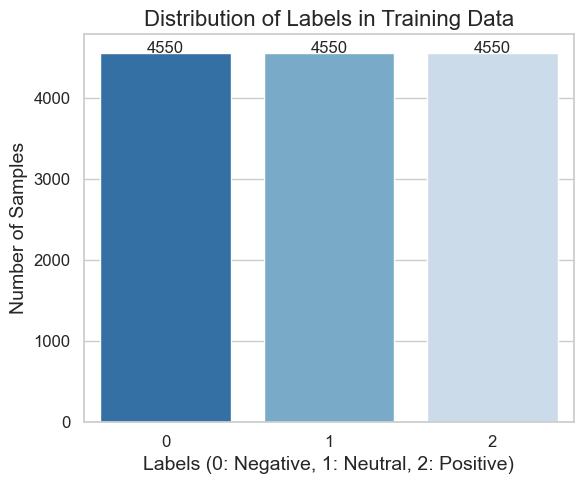

Number of batches in training loader: 854
Number of batches in dev loader: 104
Number of batches in test loader: 222


In [13]:

# %%
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import ast  # For safely evaluating strings containing Python literals
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.utils.class_weight import compute_class_weight


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = 1502  # Size of the vocabulary
# vocab_size = min(vocab_size, 2000)  # Reduce vocab size to 15,000


def index_to_one_hot(index, vocab_size):
    """ Convert an index to a one-hot encoded vector """
    one_hot = torch.zeros(vocab_size)
    one_hot[index] = 1
    return one_hot


import ast


# Define Dataset
class SentimentDataset(Dataset):
    def __init__(self, dataframe):
        self.reviews = dataframe['padded_review']
        self.labels = dataframe['label']

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        indices = self.reviews.iloc[idx]
        indices = [min(index, vocab_size - 1) for index in indices]
        one_hot_encoded = torch.stack([index_to_one_hot(index, vocab_size) for index in indices])
        return one_hot_encoded, self.labels.iloc[idx]




train_df = pd.read_csv('train_data_final_2.csv')
# train_df = train_df.sample(n=2000, random_state=42)  # Sampling 1000 examples due to dataset size

from sklearn.utils import resample

# Separate the dataset by class
class_0 = train_df[train_df['label'] == 0]  # Negative class
class_1 = train_df[train_df['label'] == 1]  # Neutral class
class_2 = train_df[train_df['label'] == 2]  # Positive class

# Find the size of the largest class
max_size = max(len(class_0), len(class_1), len(class_2))

# Oversample the minority classes to match the largest class
class_0_oversampled = resample(class_0, replace=True, n_samples=max_size, random_state=42)
class_1_oversampled = resample(class_1, replace=True, n_samples=max_size, random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=max_size, random_state=42)

# Combine the oversampled classes
train_df = pd.concat([class_0_oversampled, class_1_oversampled, class_2_oversampled])

# Shuffle the dataset
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the labels have been shifted, let's calculate the label distribution.
label_counts = train_df['label'].value_counts().sort_index()

# Set up the plot style using seaborn
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(6, 5))

# Plot the label distribution using seaborn's barplot
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues_r")

# Add annotations (text labels) above each bar
for i, count in enumerate(label_counts.values):
    ax.text(i, count + 0.5, f'{count}', ha='center', fontsize=12)

# Customize the plot's appearance
plt.xlabel('Labels (0: Negative, 1: Neutral, 2: Positive)', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Distribution of Labels in Training Data', fontsize=16)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

test_df = pd.read_csv('test_data_final_2.csv')
# test_df = test_df.sample(n=1000, random_state=42)  # Sampling 1000 examples due to dataset size

dev_df = pd.read_csv('dev_data_final_2.csv')
# dev_df = dev_df.sample(n=300, random_state=42)  # Sampling 1000 examples due to dataset size


label_counts = train_df['label'].value_counts()
class_weights = compute_class_weight('balanced', classes=[0, 1, 2], y=train_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)




test_data = test_df

# Truncate the sequences to max_length within the DataFrame
max_length = 11 # Truncate sequences to 100 tokens

# Apply truncation directly to the 'padded_review' column in each DataFrame
train_df['padded_review'] = train_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])
dev_df['padded_review'] = dev_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])

test_df['padded_review'] = test_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])


# Ensure labels are numeric (convert if necessary)
train_df['label'] = pd.to_numeric(train_df['label'])
dev_df['label'] = pd.to_numeric(dev_df['label'])
test_df['label'] = pd.to_numeric(test_df['label'])

# Create datasets
train_dataset = SentimentDataset(train_df)
dev_dataset = SentimentDataset(dev_df)
test_dataset = SentimentDataset(test_df)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print data loader counts
print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in dev loader: {len(dev_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")



In [14]:
# Print a dataloader batch
for X_batch, y_batch in train_loader:
    print("Batch X shape:", X_batch.shape)  # Shape of the batch
    print("Batch Y shape:", y_batch.shape)  # Shape of the labels
    # print("Batch X content:\n", X_batch)    # Content of one-hot encoded vectors
    print("Batch Y content:", y_batch)      # Content of labels
    break  # Break after printing the first batch to avoid printing multiple batches

Batch X shape: torch.Size([16, 11, 1502])
Batch Y shape: torch.Size([16])
Batch Y content: tensor([0, 2, 1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1])


#### FFN  

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class FFN(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, dropout_prob=0.5):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout after first hidden layer
        
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout after second hidden layer
        
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input for the linear layers
        
        # First layer with ReLU and Dropout
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        
        # Second layer with ReLU and Dropout
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        
        # Output layer (logits)
        logits = self.fc3(x)
        return logits  # CrossEntropyLoss handles the softmax


# Hyperparameters
input_size = 11 * 1502  # Adjust based on input shape (flattened input size)
hidden1_size = 256
hidden2_size = 128
output_size = 3  # 3 classes for sentiment (-ve, neutral, +ve)
learning_rate = 0.001
num_epochs = 50
patience = 5  # Early stopping patience
early_stopping_enabled = True

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FFN(input_size, hidden1_size, hidden2_size, output_size).to(device)

# Use the class weights in the CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)  # class_weights should be computed based on label distribution
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)


FFN(
  (fc1): Linear(in_features=16522, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)


In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Track losses and accuracies
train_losses = []
dev_losses = []
dev_accuracies = []

best_dev_accuracy = 0.0
best_model_state = copy.deepcopy(model.state_dict())
epochs_no_improve = 0  # Counter for early stopping

# Training Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device).long()

        # Forward pass
        logits = model(batch_X)
        
        # Compute the loss (CrossEntropyLoss includes softmax)
        loss = criterion(logits, batch_Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Evaluation on the development set
    model.eval()
    dev_preds = []
    dev_labels = []
    dev_running_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_Y in dev_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device).long()

            logits = model(batch_X)
            loss = criterion(logits, batch_Y)
            dev_running_loss += loss.item() * batch_X.size(0)

            # Get class predictions (logits -> argmax)
            preds = torch.argmax(logits, dim=1)
            dev_preds.extend(preds.cpu().numpy())
            dev_labels.extend(batch_Y.cpu().numpy())

    # Calculate development set loss and accuracy
    dev_loss = dev_running_loss / len(dev_loader.dataset)
    dev_losses.append(dev_loss)
    dev_accuracy = accuracy_score(dev_labels, dev_preds)
    dev_accuracies.append(dev_accuracy)

    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Dev Loss: {dev_loss:.4f}, Dev Accuracy: {dev_accuracy:.4f}")

    # # Calculate per-class metrics (optional)
    # precision, recall, f1, _ = precision_recall_fscore_support(dev_labels, dev_preds, average='weighted')
    # print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Early stopping and saving the best model based on dev accuracy
    if dev_accuracy > best_dev_accuracy:
        best_dev_accuracy = dev_accuracy
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1  # Increment the early stopping counter

    if early_stopping_enabled and epochs_no_improve == patience:
        print(f"Early stopping triggered after {epoch+1} epochs with no improvement.")
        break

# Load the best model state after training
model.load_state_dict(best_model_state)


Epoch [1/50], Train Loss: 0.8048, Dev Loss: 1.0606, Dev Accuracy: 0.5267
Epoch [2/50], Train Loss: 0.2536, Dev Loss: 1.2678, Dev Accuracy: 0.5418
Epoch [3/50], Train Loss: 0.0945, Dev Loss: 1.6084, Dev Accuracy: 0.5285
Epoch [4/50], Train Loss: 0.0530, Dev Loss: 1.9066, Dev Accuracy: 0.5376
Epoch [5/50], Train Loss: 0.0351, Dev Loss: 2.1877, Dev Accuracy: 0.5303
Epoch [6/50], Train Loss: 0.0262, Dev Loss: 2.1704, Dev Accuracy: 0.5345
Epoch [7/50], Train Loss: 0.0240, Dev Loss: 2.3876, Dev Accuracy: 0.5315
Early stopping triggered after 7 epochs with no improvement.


<All keys matched successfully>

In [17]:
# Function to evaluate the model on the test set
def evaluate_on_test(model, test_loader):
    model.eval()  # Set model to evaluation mode
    test_preds = []
    test_labels = []
    test_running_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device).long()

            # Forward pass to get logits
            logits = model(batch_X)

            # Compute the loss
            loss = criterion(logits, batch_Y)
            test_running_loss += loss.item() * batch_X.size(0)

            # Get class predictions from logits
            preds = torch.argmax(logits, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(batch_Y.cpu().numpy())

    # Calculate test loss and accuracy
    test_loss = test_running_loss / len(test_loader.dataset)
    test_accuracy = accuracy_score(test_labels, test_preds)

    # Print overall results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Calculate and print per-class precision, recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds)

    # Print per-class metrics
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        print(f"Class {i}: Precision: {p:.4f}, Recall: {r:.4f}, F1-Score: {f:.4f}")

    return test_loss, test_accuracy, precision, recall, f1

# After training is complete, evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_on_test(model, test_loader)


Test Loss: 1.1761, Test Accuracy: 0.5563
Class 0: Precision: 0.3740, Recall: 0.3506, F1-Score: 0.3620
Class 1: Precision: 0.5697, Recall: 0.6345, F1-Score: 0.6004
Class 2: Precision: 0.6108, Recall: 0.5540, F1-Score: 0.5810


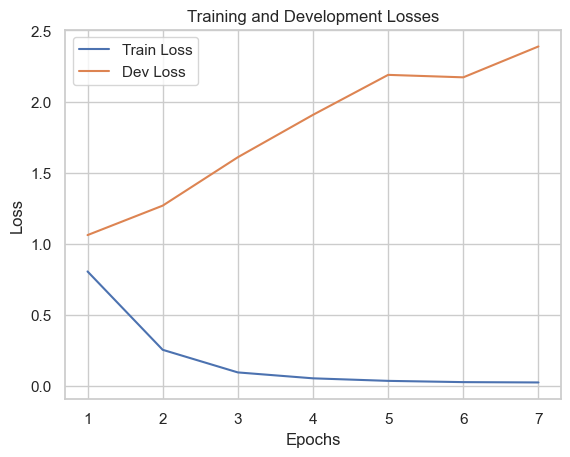

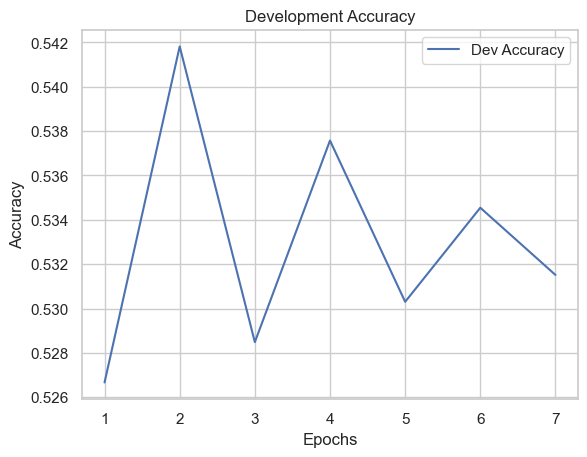

In [18]:
# Plotting the losses and accuracies
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(dev_losses) + 1), dev_losses, label='Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Development Losses')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, len(dev_accuracies) + 1), dev_accuracies, label='Dev Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Development Accuracy')
plt.legend()
plt.show()

### RNN 

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Define the RNN model for sentiment analysis
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the RNN layer (you can use LSTM/GRU as well)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden state to zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)

        # We are using the output from the last time step (out[:, -1, :])
        out = self.fc(out[:, -1, :])  # Output from the last time step
        return out

# Hyperparameters
input_size_rnn = 1502 # Adjust based on input shape
hidden_size_rnn = 256
output_size_rnn = 3  # Multi-class classification (3 sentiment classes: negative, neutral, positive)
num_layers_rnn = 1
learning_rate_rnn = 0.001
num_epochs_rnn = 10

# Initialize the RNN model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rnn = RNN(input_size_rnn, hidden_size_rnn, output_size_rnn, num_layers_rnn).to(device)
criterion_rnn = nn.CrossEntropyLoss(weight=class_weights)
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=learning_rate_rnn)



In [20]:
# Track losses and accuracies
train_losses_rnn = []
dev_losses_rnn = []
dev_accuracies_rnn = []

best_dev_accuracy_rnn = 0.0
best_model_state_rnn = copy.deepcopy(model_rnn.state_dict())

# Training Loop for RNN
for epoch in range(num_epochs_rnn):
    model_rnn.train()
    running_loss_rnn = 0.0
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device).long()

        # Forward pass through the RNN
        outputs_rnn = model_rnn(batch_X)
        
        # Compute the loss
        loss_rnn = criterion_rnn(outputs_rnn, batch_Y)

        # Backward and optimize
        optimizer_rnn.zero_grad()
        loss_rnn.backward()
        optimizer_rnn.step()

        running_loss_rnn += loss_rnn.item() * batch_X.size(0)

    epoch_loss_rnn = running_loss_rnn / len(train_loader.dataset)
    train_losses_rnn.append(epoch_loss_rnn)

    # Evaluation on the development set
    model_rnn.eval()
    dev_preds_rnn = []
    dev_labels_rnn = []
    dev_running_loss_rnn = 0.0
    with torch.no_grad():
        for batch_X, batch_Y in dev_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device).long()

            outputs_rnn = model_rnn(batch_X)
            loss_rnn = criterion_rnn(outputs_rnn, batch_Y)
            dev_running_loss_rnn += loss_rnn.item() * batch_X.size(0)

            # Get the class predictions
            preds_rnn = torch.argmax(outputs_rnn, dim=1)
            dev_preds_rnn.extend(preds_rnn.cpu().numpy())
            dev_labels_rnn.extend(batch_Y.cpu().numpy())

    dev_loss_rnn = dev_running_loss_rnn / len(dev_loader.dataset)
    dev_losses_rnn.append(dev_loss_rnn)
    dev_accuracy_rnn = accuracy_score(dev_labels_rnn, dev_preds_rnn)
    dev_accuracies_rnn.append(dev_accuracy_rnn)

    print(f"Epoch [{epoch+1}/{num_epochs_rnn}], Train Loss: {epoch_loss_rnn:.4f}, Dev Loss: {dev_loss_rnn:.4f}, Dev Accuracy: {dev_accuracy_rnn:.4f}")

    # Save the best model based on dev accuracy
    if dev_accuracy_rnn > best_dev_accuracy_rnn:
        best_dev_accuracy_rnn = dev_accuracy_rnn
        best_model_state_rnn = copy.deepcopy(model_rnn.state_dict())


Epoch [1/10], Train Loss: 0.9727, Dev Loss: 1.1439, Dev Accuracy: 0.4642
Epoch [2/10], Train Loss: 0.5304, Dev Loss: 1.4633, Dev Accuracy: 0.4436
Epoch [3/10], Train Loss: 0.3189, Dev Loss: 1.3762, Dev Accuracy: 0.5436
Epoch [4/10], Train Loss: 0.2153, Dev Loss: 1.4762, Dev Accuracy: 0.5255
Epoch [5/10], Train Loss: 0.1563, Dev Loss: 1.7548, Dev Accuracy: 0.4970
Epoch [6/10], Train Loss: 0.1342, Dev Loss: 1.9200, Dev Accuracy: 0.5721
Epoch [7/10], Train Loss: 0.1165, Dev Loss: 1.9170, Dev Accuracy: 0.5236
Epoch [8/10], Train Loss: 0.0981, Dev Loss: 2.0295, Dev Accuracy: 0.5297
Epoch [9/10], Train Loss: 0.0852, Dev Loss: 1.9993, Dev Accuracy: 0.5279
Epoch [10/10], Train Loss: 0.0816, Dev Loss: 1.9842, Dev Accuracy: 0.5000


In [21]:

# Load the best model
model_rnn.load_state_dict(best_model_state_rnn)
model_rnn.eval()

# Testing on the test set
test_preds_rnn = []
test_labels_rnn = []
with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device).long()
        outputs_rnn = model_rnn(batch_X)
        preds_rnn = torch.argmax(outputs_rnn, dim=1)
        test_preds_rnn.extend(preds_rnn.cpu().numpy())
        test_labels_rnn.extend(batch_Y.cpu().numpy())

# Calculate metrics
accuracy_rnn = accuracy_score(test_labels_rnn, test_preds_rnn)
precision_rnn, recall_rnn, f1_rnn, _ = precision_recall_fscore_support(test_labels_rnn, test_preds_rnn, average='macro')

print(f"Test Accuracy: {accuracy_rnn:.4f}")
print(f"Test Precision: {precision_rnn:.4f}")
print(f"Test Recall: {recall_rnn:.4f}")
print(f"Test F1-Score: {f1_rnn:.4f}")

# Detailed metrics for each class
precision_per_class_rnn, recall_per_class_rnn, f1_per_class_rnn, _ = precision_recall_fscore_support(
    test_labels_rnn, test_preds_rnn, labels=[0, 1, 2]
)

print("\nPer Class Metrics:")
for i in range(3):
    print(f"Class {i} - Precision: {precision_per_class_rnn[i]:.4f}, Recall: {recall_per_class_rnn[i]:.4f}, F1-Score: {f1_per_class_rnn[i]:.4f}")



Test Accuracy: 0.5822
Test Precision: 0.5656
Test Recall: 0.5235
Test F1-Score: 0.5254

Per Class Metrics:
Class 0 - Precision: 0.4343, Recall: 0.3077, F1-Score: 0.3602
Class 1 - Precision: 0.5519, Recall: 0.7944, F1-Score: 0.6513
Class 2 - Precision: 0.7106, Recall: 0.4684, F1-Score: 0.5646


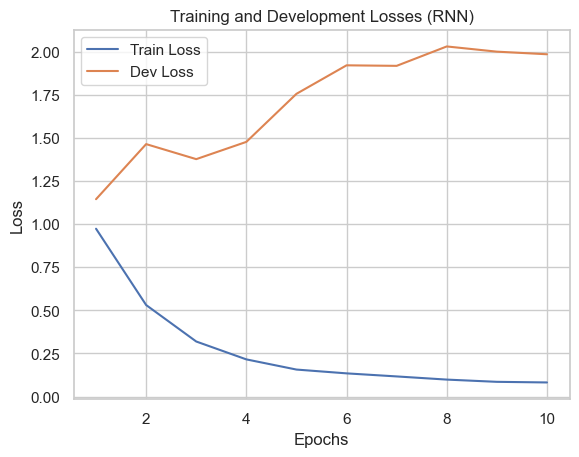

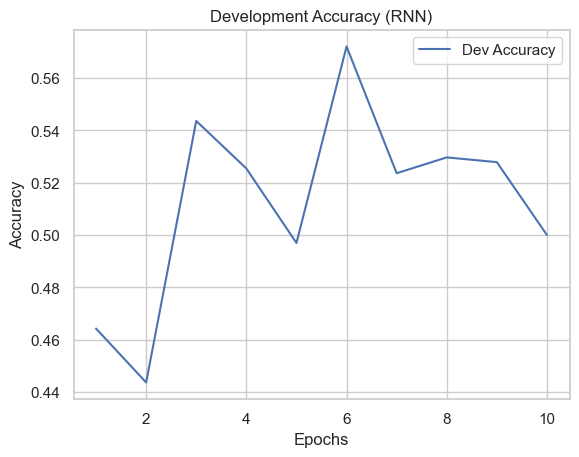

In [22]:
# Plotting the losses and accuracies
plt.figure()
plt.plot(range(1, num_epochs_rnn + 1), train_losses_rnn, label='Train Loss')
plt.plot(range(1, num_epochs_rnn + 1), dev_losses_rnn, label='Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Development Losses (RNN)')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs_rnn + 1), dev_accuracies_rnn, label='Dev Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Development Accuracy (RNN)')
plt.legend()
plt.show()


End 